# Implementing the "Phoneme Level Lyrics Alignment and Text-Informed Singing Voice Separation" paper for the Vocadito Dataset

Vocadito :

    Paper : https://arxiv.org/pdf/2110.05580.pdf
    Dataset : https://zenodo.org/record/5578807

Algorithm :

    Paper : https://hal.telecom-paris.fr/hal-03255334/file/2021_Phoneme_level_lyrics_alignment_and_text-informed_singing_voice_separation.pdf
    GitHub : https://github.com/schufo/lyrics-aligner


## Import, Setup & Conda env

In [1]:
#Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

# Imports to support MIR
!pip install mirdata
import mirdata

import librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=e96f8536ed3f644a238415b8ecef4e41986767efc876c58e521ad5e5db688ce3
  Stored in directory: /root/.cache/pip/wheels/75/ec/20/b8e937a5bcf1de547ea5ce465db7de7f6761e15e6f0a01e25f
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64923 sha256=070e495195c4f7ff0c8ccf11178

In [2]:
# Downloading the dataset and validating the installation with a CRC check.
vocadito = mirdata.initialize("vocadito")
vocadito.download()
vocadito.validate()

55.8MB [00:57, 1.02MB/s]                            
100%|██████████| 40/40 [00:00<00:00, 195.60it/s]


({'metadata': {}, 'tracks': {}}, {'metadata': {}, 'tracks': {}})

In [3]:
# Condacolab used in order to use the SoTA algorithm by K. Schulze-Forster
!pip install -q condacolab

In [4]:
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...


In [1]:
conda --version
!which conda

conda 22.11.1
/usr/local/bin/conda


## Setting up the Algorithm - 

Following the `Installation` part from https://github.com/schufo/lyrics-aligner#readme 

In [2]:
!git clone https://github.com/schufo/lyrics-aligner.git

fatal: destination path 'lyrics-aligner' already exists and is not an empty directory.


In [4]:
%cd /content/lyrics-aligner

/content/lyrics-aligner


In [5]:
# Setting up the conda environment
# /!\ This takes a long time ... 25mn in average


# Here, we run the model on a CPU, but apparently it could work on a GPU (not tried)
!conda env create -f environment_cpu.yml

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | 

## Preparing the data

Based on the `Data preparation` part in https://github.com/schufo/lyrics-aligner#readme

Automatized in Python. Working as of 23/03/2022

In [6]:
# Used to automatize the access to the CMU dictionary : http://www.speech.cs.cmu.edu/tools/lextool.html

!pip install beautifulsoup4
import os
import requests
from bs4 import BeautifulSoup
import ssl
from urllib.request import urlretrieve
import urllib.parse
from urllib.request import urlopen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.2/132.2 kB 3.8 MB/s eta 0:00:00


In [7]:
!NAME=VOCADITO
NAME='VOCADITO'

In [8]:
# Fix to apply on the Vocadito lyrics of 5 files :

# 23 : changing 'à' in 'a' and 'trempez-la' in 'trempez la'
with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_23_lyrics.txt', 'r') as f:
    text = f.read()
    text = text.replace('à', 'a')
    text = text.replace('trempez-la', 'trempez la')

with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_23_lyrics.txt', 'w') as f:
    f.write(text)

# 30 : changing 'à' in 'a'
with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_30_lyrics.txt', 'r') as f:
    text = f.read()
    text = text.replace('à', 'a')

with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_30_lyrics.txt', 'w') as f:
    f.write(text)

# 31 : changing 'à' in 'a'
with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_31_lyrics.txt', 'r') as f:
    text = f.read()
    text = text.replace('à', 'a')

with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_31_lyrics.txt', 'w') as f:
    f.write(text)


# 35 : Removing the chinese characters that are at the end of the lyrics
import re
with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_35_lyrics.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = re.sub('[\u4e00-\u9fff]+', '', text)
text = text.replace('-','')

with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_35_lyrics.txt', 'w', encoding='utf-8') as f:
    f.write(text)

# 36 : Removing the chinese characters that are at the end of the lyrics
with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_36_lyrics.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = re.sub('[\u4e00-\u9fff]+', '', text)
text = text.replace('-','')

with open('/root/mir_datasets/vocadito/Annotations/Lyrics/vocadito_36_lyrics.txt', 'w', encoding='utf-8') as f:
    f.write(text)



In [9]:
# 1 - Generate a .txt-file with a list of unique words - VOCADITO_word_list.txt
!python make_word_list.py /root/mir_datasets/vocadito/Annotations/Lyrics --dataset-name $NAME

with open(f'/content/lyrics-aligner/files/{NAME}_word_list.txt', 'r') as file:
    data = file.read().replace('\n', ' ')
    words = data.split()

print(words)

["'cause", "'oe", 'a', "a'e", 'about', 'acuerdo', 'again', 'ah', 'ainsi', 'ako', 'al', 'alarm', 'alimango', 'all', 'allant', 'allez', 'aloha', 'alone', 'and', 'ang', 'anirem', 'any', 'arar', 'are', 'arrabales', 'arreando', 'as', 'at', 'au', 'aussi', 'awfully', 'ay', 'ba', 'baa', 'baby', 'back', 'bags', 'balikat', 'ball', 'bawang', 'be', 'bed', 'been', 'best', 'bien', 'binili', 'birthday', 'bitsy', 'black', 'bleus', 'blizzard', 'board', 'bog', 'boy', 'but', 'buy', 'by', 'bào', 'bǎo', 'cabasset', 'cada', 'call', 'came', "can't", 'car', 'care', 'cause', 'ces', 'chata', 'chaud', 'chimney', 'christmas', 'chuán', 'claim', 'claus', 'clementine', 'click', 'close', 'closed', 'coll', 'come', 'complete', 'coughs', 'courait', 'coyote', 'cracker', 'crocodile', 'crocodiles', 'crocrocros', 'crowd', 'cul', 'cute', 'dagat', 'dalawang', 'daliri', 'dame', 'dans', "darlin'", 'de', 'dear', 'des', 'di', 'diamonds', 'digue', 'dilang', 'ding', 'disait', 'disent', 'do', 'dog', 'doggie', "doggie's", "don't", 'd

In [10]:
# 2 - Go to http://www.speech.cs.cmu.edu/tools/lextool.html, upload NAME_word_list.txt as word file, and click COMPILE.
# We automatize this step in Python using the BeautifulSoup library

# make a GET request to the webpage containing the form
response = requests.get("http://www.speech.cs.cmu.edu/tools/lextool.html")

# parse the HTML content using Beautiful Soup
soup = BeautifulSoup(response.content, 'html.parser')

form = soup.find('form', {'name': 'lextool'})

# We want to submit the file NAME_word_list.txt generated in step #1
form_data = {
    'wordfile': ('filename.txt', open(f"/content/lyrics-aligner/files/{NAME}_word_list.txt", 'rb'), 'text/plain')
}

submit_button = form.find('input', {'type': 'submit', 'value': ' COMPILE '})

# URL of the form action
action_url = form['action']

# Submit the form by sending a POST request to the action URL with the form data
response = requests.post('http://www.speech.cs.cmu.edu/cgi-bin/tools/logios/lextool2.pl', files=form_data)

# Verify that the form submission was successful
if response.status_code == 200:
    print("Form submitted successfully!")
    resp = response.content
else:
    print("Form submission failed : " + str(response))
    print(response)

Form submitted successfully!


In [11]:
# From the response, we recover the URL of the *.dict file generated
import re 

match = re.search(r'DICT\s*(http\S*\.dict)', resp.decode())
if match:
    url = match.group(1)
    print(url)

# Send a GET request to the URL and get the response content
response = requests.get(url)
# Verify that the form submission was successful
if response.status_code == 200:
    print("Received the .dict successfully!")
else:
    print("Issue receiving the .dict : " + str(response))
    print(response)

http://www.speech.cs.cmu.edu//tools/product/1679934221_1335950//2376.dict
Received the .dict successfully!


In [12]:
# Step #4 : Copy the whole list and paste it into NAME_word2phoneme.txt in the files directory
# Process automatized using Python and BeautifulSoup.

with open(f'/content/lyrics-aligner/files/{NAME}_word2phonemes.txt', 'wb') as f:
    f.write(response.content)

In [13]:
# Step #5 : Running this command will generate a Python dictionary to translate each word into phonemes and save it as NAME_word2phonemes.pickle in files.
!python make_word2phoneme_dict.py --dataset-name $NAME


In [14]:
print(NAME)

VOCADITO


## Using the algorithm

Part based on the `Usage` part of https://github.com/schufo/lyrics-aligner#readme

In [15]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 30.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 201.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB

In [16]:
!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 48.1 MB/s eta 0:00:00


In [17]:
# To make the Algorithm work, the wav files and the lyrics file must avec the name : vocadito_xx
%cd /root/mir_datasets/vocadito/Annotations
!mkdir Lyrics_process && cp ./Lyrics/vocadito_*_lyrics.txt Lyrics_process && cd Lyrics_process && rename 's/_lyrics//' *
%cd -

/root/mir_datasets/vocadito/Annotations
/content/lyrics-aligner


In [18]:
# We run the model for every file in our folder

!python align.py /root/mir_datasets/vocadito/Audio  /root/mir_datasets/vocadito/Annotations/Lyrics_process \
--lyrics-format w --onsets pw --dataset-name $NAME --vad-threshold 0

Running model on CPU.
Processing vocadito_1.wav ...
Done.
Processing vocadito_10.wav ...
Done.
Processing vocadito_11.wav ...
Done.
Processing vocadito_12.wav ...
Done.
Processing vocadito_13.wav ...
Done.
Processing vocadito_14.wav ...
Done.
Processing vocadito_15.wav ...
Done.
Processing vocadito_16.wav ...
Done.
Processing vocadito_17.wav ...
Done.
Processing vocadito_18.wav ...
Done.
Processing vocadito_19.wav ...
Done.
Processing vocadito_2.wav ...
Done.
Processing vocadito_20.wav ...
Done.
Processing vocadito_21.wav ...
Done.
Processing vocadito_22.wav ...
Done.
Processing vocadito_23.wav ...
Done.
Processing vocadito_24.wav ...
Done.
Processing vocadito_25.wav ...
Done.
Processing vocadito_26.wav ...
Done.
Processing vocadito_27.wav ...
Done.
Processing vocadito_28.wav ...
Done.
Processing vocadito_29.wav ...
Done.
Processing vocadito_3.wav ...
Done.
Processing vocadito_30.wav ...
Done.
Processing vocadito_31.wav ...
Done.
Processing vocadito_32.wav ...
Done.
Processing vocadito

## 'Accuracy metric'

In [31]:
import librosa
import numpy as np

In [29]:
def calculate_onsets(number):
  y, sr = librosa.load(f'/root/mir_datasets/vocadito/Audio/vocadito_{number}.wav')
  librosa.onset.onset_detect(y=y, sr=sr, units='time')
  o_env = librosa.onset.onset_strength(y=y, sr=sr)
  times = librosa.times_like(o_env, sr=sr)
  onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

  return list(librosa.frames_to_time(onset_frames))

def improving_onsets(number):

  timing = []

  with open(f'/content/lyrics-aligner/outputs/VOCADITO/word_onsets/vocadito_{number}.txt') as fp:
    csvreader = csv.reader(fp)
    for line in csvreader:
      a,b = line[0].split('\t')
      timing.append(float(b))

  onsets = calculate_onsets(number)
  onsets_improved = []
  for t in timing:
    tmp_a = []
    for o in onsets:
      tmp_a.append(abs(t-o))
    if(min(tmp_a) <= 1): #Inf a 1s
      onsets_improved.append(onsets[np.argmin(tmp_a)])

  return(onsets_improved, timing)

def calculate_metric(number):

  (onsets_improved, timing) = improving_onsets(number)

  tmp = 0
  ouch = 0
  total = 0
  print(f'len timing : {len(timing)} ; len onsets_improved : {len(onsets_improved)}')
  for i in range(min(len(timing),len(onsets_improved))):
    total += 1
    tmp_ = abs(timing[i]-onsets_improved[i])
    tmp += tmp_
    if tmp_ > 0.3: #300 ms accu 
      ouch += 1

  return (tmp/len(timing),ouch,total)

In [32]:
calculate_metric(6)

len timing : 36 ; len onsets_improved : 36


(0.08344268077601427, 2, 36)

In [33]:
# We apply for every file :

mean_ms = []
ouch_overall = []
total_overall = []
f0_indiv = []

for i in range(40):
  print(f'Processing file n°{i+1} - {(i+1)/40*100}% done so far')
  (out1, out2, out3) = calculate_metric(i+1)
  print(f'Mean accuracy (ms) : {out1*1000} - F0-score with 0.3s tolerance : {100-out2/out3*100}')
  mean_ms.append(out1*1000)
  ouch_overall.append(out2)
  total_overall.append(out3)
  f0_indiv.append(100-out2/out3*100)
  print('---')

print('Processing finished !')

Processing file n°1 - 2.5% done so far
len timing : 33 ; len onsets_improved : 33
Mean accuracy (ms) : 79.09956709956703 - F0-score with 0.3s tolerance : 96.96969696969697
---
Processing file n°2 - 5.0% done so far
len timing : 21 ; len onsets_improved : 21
Mean accuracy (ms) : 81.24392614188588 - F0-score with 0.3s tolerance : 100.0
---
Processing file n°3 - 7.5% done so far
len timing : 21 ; len onsets_improved : 21
Mean accuracy (ms) : 57.90821725515606 - F0-score with 0.3s tolerance : 100.0
---
Processing file n°4 - 10.0% done so far
len timing : 32 ; len onsets_improved : 32
Mean accuracy (ms) : 73.89682539682508 - F0-score with 0.3s tolerance : 96.875
---
Processing file n°5 - 12.5% done so far
len timing : 28 ; len onsets_improved : 28
Mean accuracy (ms) : 79.81988986070589 - F0-score with 0.3s tolerance : 100.0
---
Processing file n°6 - 15.0% done so far
len timing : 36 ; len onsets_improved : 36
Mean accuracy (ms) : 83.44268077601427 - F0-score with 0.3s tolerance : 94.4444444

We have the following metrics :
   Mean difference between calculated between onsets and beginning of the word (in ms) : 101.93031956215255
   Variance related : 17934.797294915632
   Minimum value : 55.80498866213159 for the track n°28
   Maximum value : 900.2227261274878 for the track n°17

   Mean F0-score with 0.3s tolerance - Global : 96.49532710280374%
   Mean F0-score with 0.3s tolerance - Individuals : 96.26860875946326%
   Variance related : 156.53423789273194
   Minimum value : 24.24242424242425 for the track n°17
   Maximum value : 100.0 for the track n°2


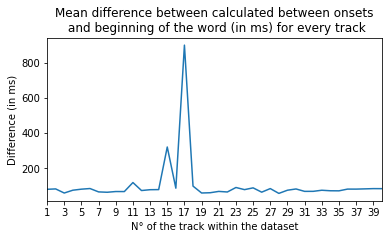

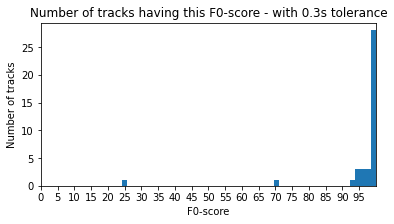

In [34]:
plt.rcParams['figure.figsize'] = (6,3)
plt.figure()
plt.plot(np.arange(1,41),mean_ms)
plt.xlabel('N° of the track within the dataset')
plt.ylabel('Difference (in ms)')
plt.title('Mean difference between calculated between onsets\n and beginning of the word (in ms) for every track')
plt.xlim(1,40)

plt.xticks(np.arange(1,41)[::2])

plt.figure()
plt.hist(f0_indiv,50)
plt.xlabel('F0-score')
plt.ylabel('Number of tracks')
plt.title('Number of tracks having this F0-score - with 0.3s tolerance')
plt.xlim(20,100)
plt.xticks(np.arange(100)[::5])
# 1st metric : mean ms_delay
# mean ; var ; ...
print('We have the following metrics :')
print(f'   Mean difference between calculated between onsets and beginning of the word (in ms) : {np.mean(mean_ms)}')
print(f'   Variance related : {np.var(mean_ms)}')
print(f'   Minimum value : {min(mean_ms)} for the track n°{np.argmin(mean_ms)+1}')
print(f'   Maximum value : {max(mean_ms)} for the track n°{np.argmax(mean_ms)+1}')
#plot histo

print('')

# 2nd metric : F0-score for individual ; min & max for indiv ; total err out of total 
print(f'   Mean F0-score with 0.3s tolerance - Global : {100 - np.sum(ouch_overall)/np.sum(total_overall)*100}%')
print(f'   Mean F0-score with 0.3s tolerance - Individuals : {np.mean(f0_indiv)}%')
print(f'   Variance related : {np.var(f0_indiv)}')
print(f'   Minimum value : {min(f0_indiv)} for the track n°{np.argmin(f0_indiv)+1}')
print(f'   Maximum value : {max(f0_indiv)} for the track n°{np.argmax(f0_indiv)+1}')

In [35]:
mean_ms.pop(16)
ouch_overall.pop(16)
total_overall.pop(16)
f0_indiv.pop(16)

24.24242424242425

In [36]:
# 1st metric : mean ms_delay
# mean ; var ; ...
print('We have the following metrics :')
print(f'   Mean difference between calculated between onsets and beginning of the word (in ms) : {np.mean(mean_ms)}')
print(f'   Variance related : {np.var(mean_ms)}')
print(f'   Minimum value : {min(mean_ms)} for the track n°{np.argmin(mean_ms)+1}')
print(f'   Maximum value : {max(mean_ms)} for the track n°{np.argmax(mean_ms)+1}')
#plot histo

print('')

# 2nd metric : F0-score for individual ; min & max for indiv ; total err out of total 
print(f'   Mean F0-score with 0.3s tolerance - Global : {100 - np.sum(ouch_overall)/np.sum(total_overall)*100}%')
print(f'   Mean F0-score with 0.3s tolerance - Individuals : {np.mean(f0_indiv)}%')
print(f'   Variance related : {np.var(f0_indiv)}')
print(f'   Minimum value : {min(f0_indiv)} for the track n°{np.argmin(f0_indiv)+1}')
print(f'   Maximum value : {max(f0_indiv)} for the track n°{np.argmax(f0_indiv)+1}')

We have the following metrics :
   Mean difference between calculated between onsets and beginning of the word (in ms) : 81.46128349637472
   Variance related : 1635.4063937366275
   Minimum value : 55.80498866213159 for the track n°27
   Maximum value : 320.0000000000001 for the track n°15

   Mean F0-score with 0.3s tolerance - Global : 98.40127897681855%
   Mean F0-score with 0.3s tolerance - Individuals : 98.11543400348991%
   Variance related : 24.117397021275323
   Minimum value : 70.37037037037038 for the track n°15
   Maximum value : 100.0 for the track n°2


## Plotting


In [42]:
import csv
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [40]:
def plotting_pred(number, starting_time, finish_time):
  wav_path = f'/root/mir_datasets/vocadito/Audio/vocadito_{number}.wav'
  F0_path = f'/root/mir_datasets/vocadito/Annotations/F0/vocadito_{number}_f0.csv'
  lyrics_path = f'/root/mir_datasets/vocadito/Annotations/Lyrics_process/vocadito_{number}.txt'
  notes_a1_path = f'/root/mir_datasets/vocadito/Annotations/Notes/vocadito_{number}_notesA1.csv'
  notes_a2_path = f'/root/mir_datasets/vocadito/Annotations/Notes/vocadito_{number}_notesA2.csv'
  words_onsets_path = f'/content/lyrics-aligner/outputs/VOCADITO/word_onsets/vocadito_{number}.txt'
  phoneme_onsets_path = f'/content/lyrics-aligner/outputs/VOCADITO/phoneme_onsets/vocadito_{number}.txt'

  time_ind = []
  f0_ind = []

  time_a1_ind = []
  dur_a1_ind = []
  pitch_a1 = []

  time_a2_ind = []
  dur_a2_ind = []
  pitch_a2 = []  

  word = []
  timing = []
  dico_word = {}

  phonemes = []
  timing_pho = []
  dico_pho = {}

  with open(F0_path) as fp:
      csvreader = csv.reader(fp)
      for line in csvreader:
          time_ind.append(float(line[0]))
          f0_ind.append(float(line[1]))

  with open(notes_a1_path) as fp:
      csvreader = csv.reader(fp)
      for line in csvreader:
          time_a1_ind.append(float(line[0]))
          pitch_a1.append(float(line[1]))
          dur_a1_ind.append(float(line[2]))  

  with open(notes_a2_path) as fp:
      csvreader = csv.reader(fp)
      for line in csvreader:
          time_a2_ind.append(float(line[0]))
          pitch_a2.append(float(line[1]))
          dur_a2_ind.append(float(line[2]))  

  with open(words_onsets_path) as fp:
      csvreader = csv.reader(fp)
      for line in csvreader:
        a,b = line[0].split('\t')
        word.append(a)
        timing.append(float(b))
  # Iterate through the lists and add key-value pairs to the dictionary
  for i in range(len(word)):
      dico_word[timing[i]] = word[i]

  with open(phoneme_onsets_path) as fp:
      csvreader = csv.reader(fp)
      for line in csvreader:
        a,b = line[0].split('\t')
        phonemes.append(a)
        timing_pho.append(float(b))
  # Iterate through the lists and add key-value pairs to the dictionary
  for i in range(len(phonemes)):
      dico_pho[timing_pho[i]] = phonemes[i]

  # Onsets from Librosa :
  (onsets_librosa,_) = improving_onsets(number)

  plt.rcParams['figure.figsize'] = (20,8)

  fig, ax = plt.subplots()

  for i in range(len(time_a1_ind)):
    if time_a1_ind[i] > starting_time and time_a1_ind[i] < finish_time:
      ax.add_patch(Rectangle((time_a1_ind[i],pitch_a1[i]-5), dur_a1_ind[i], 10, alpha=0.2, facecolor='b'))

  for i in range(len(time_a2_ind)):
    if time_a2_ind[i] > starting_time and time_a2_ind[i] < finish_time:
      ax.add_patch(Rectangle((time_a2_ind[i],pitch_a2[i]-5), dur_a2_ind[i], 10, alpha=0.2, facecolor='r'))

  tmp = min(x for x in f0_ind if x != 0) - 40
  for i in dico_word.keys():
    if(i > starting_time and i < finish_time):
      ax.text(i, tmp, f'{dico_word[i]}', size=30)
      plt.axvline(x=i, alpha = 0.5, c ='maroon', ls='-')

  tmp = min(x for x in f0_ind if x != 0) - 70
  for i in dico_pho.keys():
    if(i > starting_time and i < finish_time):
      ax.text(i, tmp, f'{dico_pho[i]}',size=15)
      plt.axvline(x=i, alpha = 0.2, c='purple', ls='dotted')

  for i in range(len(f0_ind)):
    if(time_ind[i] < finish_time and time_ind[i] > starting_time):
      if f0_ind[i] > 10:
        ax.plot(time_ind[i], f0_ind[i],'ok',alpha = 0.4)
      else:
        ax.plot(time_ind[i], 100)
      
  for o in onsets_librosa:
    if( o > starting_time and o < finish_time ):
      plt.axvline(x=o, alpha = 0.5,c='darkgreen',ls='--')

  plt.xlim(xmin=starting_time, xmax=finish_time)
  plt.ylim(ymin=tmp - 70, ymax = max(f0_ind)+20)

  #Legend 
  plt.axvline(x=-1, alpha = 0.2, c='purple', ls='dotted', label = 'Onset of a phoneme')
  plt.axvline(x=-1, alpha = 0.5, c ='maroon', ls='-', label = 'Onset of a word')
  ax.plot(-1, 0,'ok',alpha = 0.4, label='A pitch value')
  ax.add_patch(Rectangle((-1,0), 0, 0, alpha=0.2, facecolor='b', label = 'Annotations from A1'))
  ax.add_patch(Rectangle((-1,0), 0, 0, alpha=0.2, facecolor='r', label = 'Annotations from A2'))
  plt.axvline(x=-1, alpha = 0.5,c='darkgreen',ls='--', label = 'Onset from Librosa')
  plt.legend()
  plt.xlabel('Time (sec)')
  plt.ylabel('Pitch (frequency)')

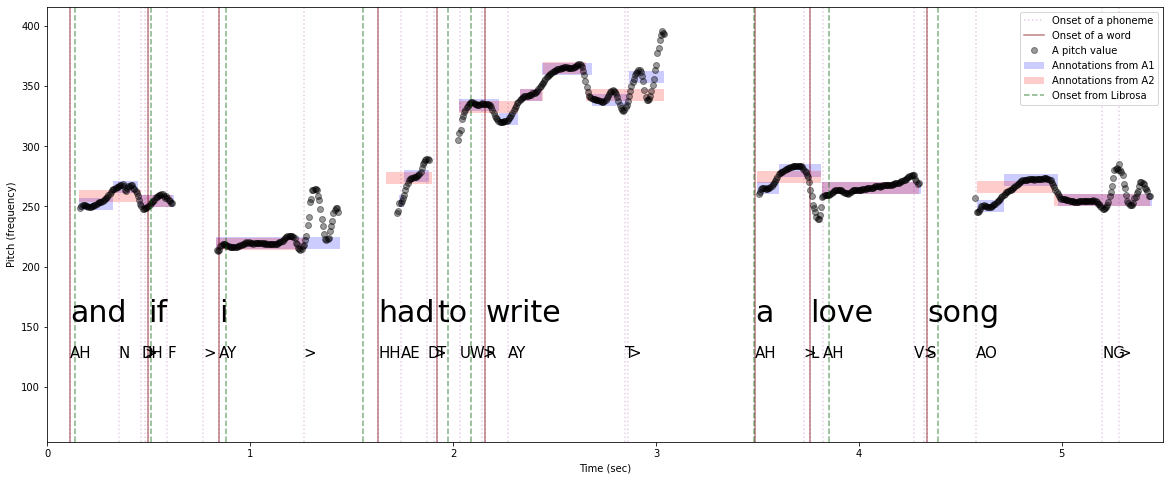

In [41]:
plotting_pred(number = 6,starting_time = 0, finish_time = 5.5)

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


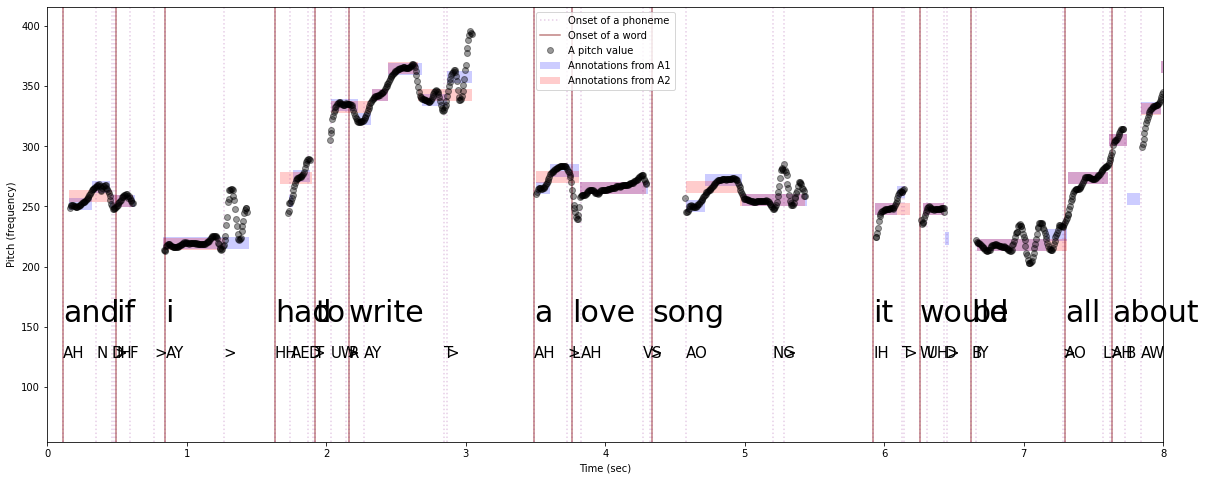

In [22]:
plotting_pred(number = 6,starting_time = 0, finish_time = 8)

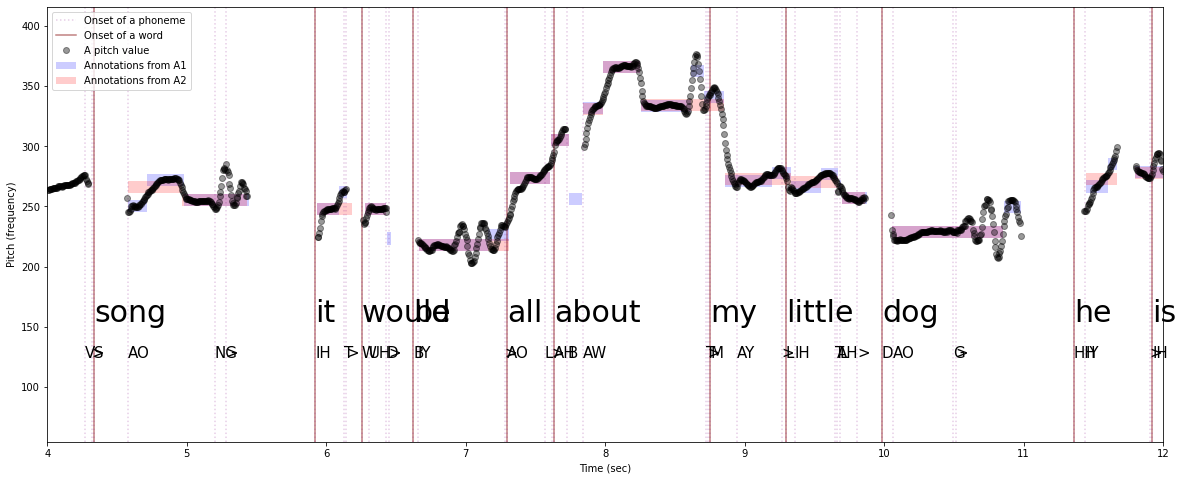

In [23]:
plotting_pred(number = 6,starting_time = 4, finish_time = 12)